# Understanding I.I.D. and Non-I.I.D. Data in Federated Learning

In the context of federated learning, data distribution among participants is a critical factor that influences model performance. Data can be categorized into two main types based on its distribution across participants:

- **Independently and Identically Distributed (I.I.D.)**: In an i.i.d. scenario, the data is assumed to be distributed uniformly across all participants. Each participant's data is a representative sample of the overall dataset, containing a similar mix and number of samples from each class.

- **Non-Independently and Identically Distributed (Non-I.I.D.)**: Non-i.i.d. data, on the other hand, does not follow a uniform distribution. Participants may have data that is skewed towards one or several classes, and the number of samples can vary significantly. This scenario is more reflective of real-world federated learning settings, where data naturally varies between different devices or users due to personal preferences, usage patterns, or environmental factors.

## Introduction to the Dirichlet Distribution
The Dirichlet distribution is a family of continuous multivariate probability distributions parameterized by a vector of positive reals $\alpha = (\alpha_1, \alpha_2, \dots, \alpha_K)$ where
$K$ is the number of categories or classes. It is often used in Bayesian statistics, machine learning, and other fields to model the probabilities of outcomes in a multinomial distribution.

### The Dirichlet Distribution Equation
The probability density function (PDF) of the Dirichlet distribution for a K-dimensional vector $x=(x_1,\dots, x_K)$ where $x_i$ represents the probability of the $i^\text{th}$ category, and $\sum_{i=1}^K x_i = 1$, is given by:
$$P(x_1, ..., x_K; \alpha_1, ..., \alpha_K) = \frac{1}{B(\alpha)} \prod_{i=1}^{K} x_i^{\alpha_i - 1}$$

B(α) is the multinomial Beta function, a normalization constant ensuring that the probabilities sum up to 1, defined as:
$$B(\alpha) = \frac{\prod_{i=1}^{K} \Gamma(\alpha_i)}{\Gamma\left(\sum_{i=1}^{K} \alpha_i\right)}$$

With $\Gamma{}$ representing the Gamma function.

### Understanding the Concentration Parameter $\alpha$

The vector $\alpha$ is known as the concentration parameter of the Dirichlet distribution. Each element $\alpha_i$ of this vector corresponds to a category and influences the distribution of probability mass among the categories:

- When all $\alpha_i > 1$, the distribution is centered, with most of the probability mass concentrated around the uniform distribution, leading to more balanced outcomes.
- When all $\alpha_i = 1$, the Dirichlet distribution becomes the uniform distribution over the simplex, with all outcomes equally likely.
- When all $\alpha_i < 1$, the distribution becomes more skewed, favoring higher probabilities of extreme distributions, concentrating most of the probability mass on fewer categories.

### Visualizing the Effect of $\alpha$
To illustrate the effect of the concentration parameter $\alpha$ on the Dirichlet distribution, consider a simple case with three outcomes (a ternary distribution). I'll visualize how varying $\alpha$ affects the distribution of probabilities among these three outcomes.

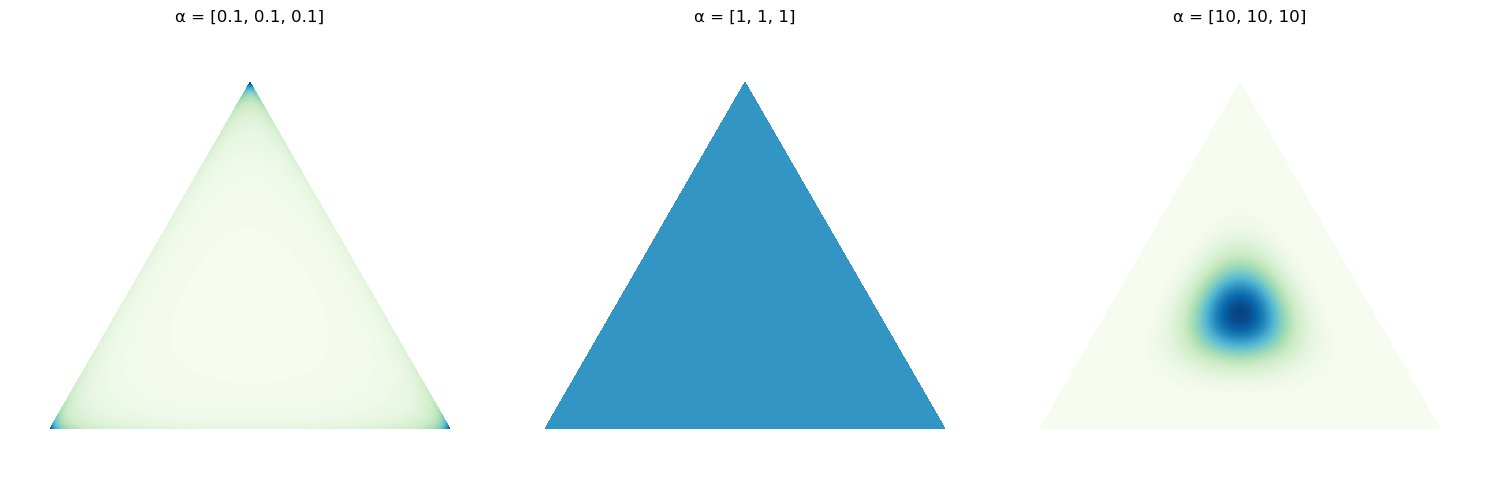

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import dirichlet
from matplotlib.tri import Triangulation

def plot_dirichlet_equilateral(alpha, ax, title):
    # Define vertices of an equilateral triangle
    vertices = np.array([[0, 0], [1, 0], [0.5, np.sqrt(3) / 2]])

    # Create a mesh on the simplex, avoiding the edges
    buffer = 0.025  # Buffer to avoid zero values
    x = np.linspace(buffer, 1 - buffer, 100)
    X, Y = np.meshgrid(x, x)
    X = X.flatten()
    Y = Y.flatten()
    Z = 1 - X - Y
    mask = Z >= buffer
    X, Y, Z = X[mask], Y[mask], Z[mask]

    # Convert simplex coordinates (barycentric) to Cartesian coordinates for plotting
    points = np.stack([X, Y, Z]).T @ vertices

    # Create triangulation
    tri = Triangulation(points[:, 0], points[:, 1])

    # Compute Dirichlet PDF
    pdf = dirichlet.pdf(np.stack([X, Y, Z]), alpha)

    # Plot
    ax.tricontourf(tri, pdf, cmap='GnBu', levels=100)
    ax.set_title(title)
    ax.axis('equal')
    ax.axis('off')  # Hide axis for clarity

    # Draw triangle border for reference
    # ax.plot(*zip(*vertices, vertices[0]), c='k')

# Alpha values to illustrate
alphas = [[0.1, 0.1, 0.1], [1, 1, 1], [10, 10, 10]]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for alpha, ax in zip(alphas, axs):
    plot_dirichlet_equilateral(alpha, ax, f'α = {alpha}')
plt.tight_layout()
plt.show()

The visualization above showcases the Dirichlet distribution plotted over an equilateral triangle, representing a ternary distribution among three categories or classes. This provides a view of how probabilities are distributed across these categories under different concentration parameters ($\alpha$) settings.

- Uniform Distribution ($\alpha = 1$): When all $\alpha$ values are set to 1, the Dirichlet distribution results in a uniform distribution over the triangle. This means that all combinations of probabilities for the three categories are equally likely. For data distribution, this scenario represents a perfectly balanced and i.i.d. dataset where each category is equally represented.

- Concentration around the Mean ($\alpha > 1$): As the $\alpha$ values increase above 1, the distribution becomes more concentrated around the center of the triangle, indicating a tendency towards equal probabilities for all categories. This suggests a more balanced dataset but with less variation in the data distribution among participants.

- Highly Skewed towards Extremes ($\alpha < 1$): When $\alpha$ values are less than 1, the distribution becomes more skewed towards the vertices of the triangle. This indicates a higher likelihood of extreme distributions where one category dominates over the others. In federated learning, this scenario simulates a highly non-i.i.d. dataset where some participants may have data predominantly from one category.

## Simulating Non-I.I.D. Data with the Dirichlet Distribution
To study and understand the challenges posed by non-i.i.d. data in federated learning, we can simulate such conditions in a controlled environment. The Dirichlet distribution, a family of continuous multivariate probability distributions, is often used for this purpose. By adjusting the concentration parameter (α) of the Dirichlet distribution, we can control the degree of skewness in the data distribution among participants, thus simulating various non-i.i.d. scenarios.

The visualization below compares class distributions among participants in both i.i.d. and non-i.i.d. scenarios, with the non-i.i.d. data distribution generated using the Dirichlet distribution.

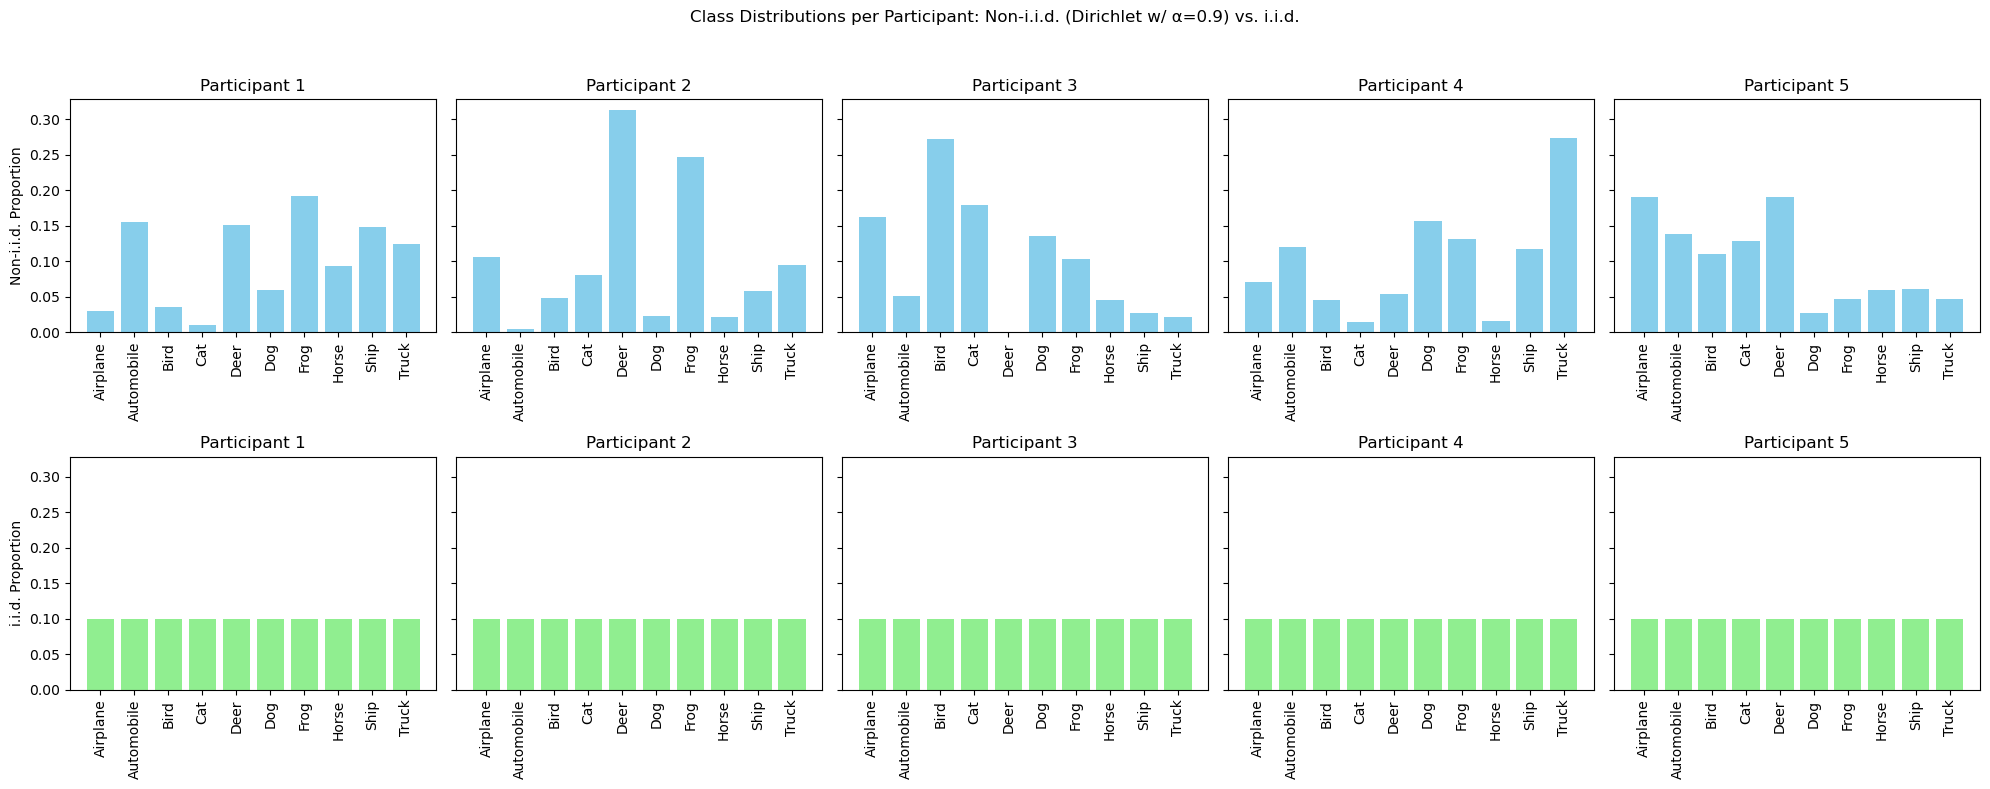

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def plot_distributions(axs, distributions, row_index, title_prefix, ylabel, color):
    for i in range(num_participants):
        axs[row_index, i].bar(cifar10_classes, distributions[i], color=color)
        axs[row_index, i].set_title(f'{title_prefix} {i+1}')
        if i == 0:
            axs[row_index, i].set_ylabel(ylabel)
        axs[row_index, i].tick_params(axis='x', rotation=90)

# Parameters for the comparison
num_classes = 10  # Number of classes in CIFAR-10
num_participants = 5  # Number of participants to simulate
alpha = 0.9  # Dirichlet concentration parameter for non-i.i.d. data

# Generate Dirichlet distributions for non-i.i.d. scenario
distributions_non_iid = np.random.dirichlet(alpha=np.ones(num_classes) * alpha, size=num_participants)

# Simulate i.i.d. scenario with uniform distribution
distributions_iid = np.full((num_participants, num_classes), 1 / num_classes)

# CIFAR-10 class names
cifar10_classes = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

# Plotting setup
fig, axs = plt.subplots(2, num_participants, figsize=(20, 8), sharey=True)
plt.suptitle(f'Class Distributions per Participant: Non-i.i.d. (Dirichlet w/ α={alpha}) vs. i.i.d.')

# Plot non-i.i.d. distributions
plot_distributions(axs, distributions_non_iid, 0, 'Participant', 'Non-i.i.d. Proportion', 'skyblue')

# Plot i.i.d. distributions
plot_distributions(axs, distributions_iid, 1, 'Participant', 'i.i.d. Proportion', 'lightgreen')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


- I.I.D. Data: The uniform distribution of classes across all participants ensures that each participant's data is a mini-representation of the entire dataset. This uniformity simplifies model training and aggregation, as each local update is likely to be relevant to the global model.

- Non-I.I.D. Data (Dirichlet): The skewed class distributions, generated using the Dirichlet distribution, highlight the diversity and imbalance that can exist in real-world data. Such variability introduces challenges in model training, convergence, and fairness, as some classes may be underrepresented in the global dataset.

## Comparing the Effect of $\alpha$ on CIFAR10 Class Distributions

To see how the concentration parameter $\alpha$ impacts the class distribution, we once again look at Dirichlet distributions with $\alpha = [0.1, 1, 10]$. 

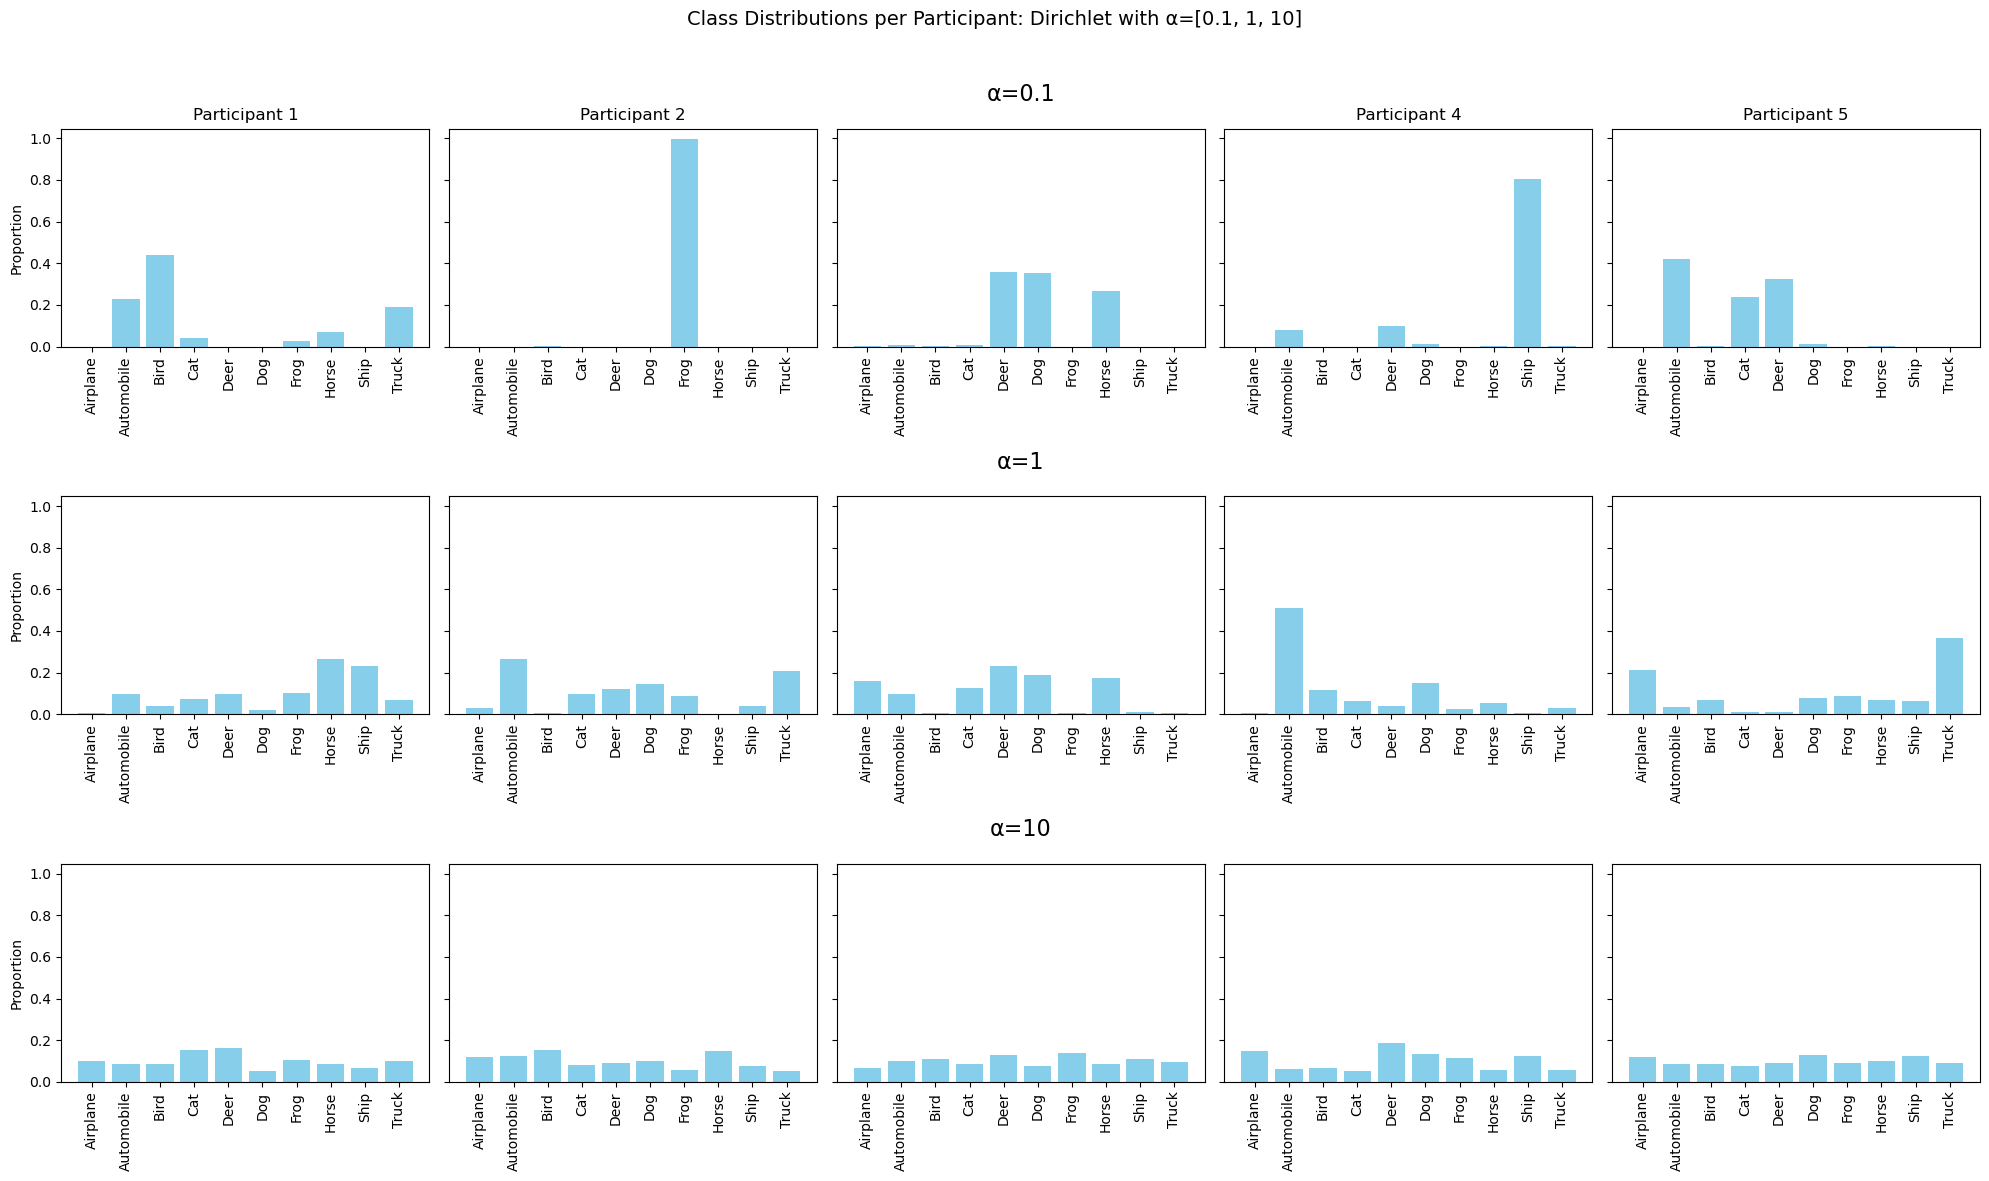

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def plot_distributions(axs, distributions, row_index, alpha, ylabel, color):
    for i in range(num_participants):
        if len(alphas) > 1:  # If axs is a 2D array
            ax = axs[row_index, i]
        else:  # If axs is a 1D array
            ax = axs[i]

        ax.bar(cifar10_classes, distributions[i], color=color)
        ax.set_title(f'Participant {i+1}' if row_index == 0 else '')
        if i == 0:
            ax.set_ylabel(ylabel)

        ax.tick_params(axis='x', rotation=90)

    # Set alpha title for the first plot in each row
    if len(alphas) > 1:
        axs[row_index, num_participants//2].set_title(f'α={alpha}', fontsize=16, pad=20, loc='center')
    else:
        axs[num_participants//2].set_title(f'α={alpha}', fontsize=16, pad=20, loc='center')

# Parameters for the comparison
num_classes = 10  # Number of classes in CIFAR-10
num_participants = 5  # Number of participants to simulate
alphas = [0.1, 1, 10]  # Dirichlet concentration parameters

# Generate Dirichlet distributions
distributions_dirichlet = [np.random.dirichlet(alpha=np.ones(num_classes) * alpha, size=num_participants) for alpha in alphas]

# CIFAR-10 class names
cifar10_classes = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

# Plotting setup
fig, axs = plt.subplots(len(alphas), num_participants, figsize=(20, len(alphas) * 4), sharey=True, squeeze=False)
plt.suptitle(f'Class Distributions per Participant: Dirichlet with α={alphas}', fontsize=14)

# Plot non-i.i.d. distributions
for i, (alpha, dist) in enumerate(zip(alphas, distributions_dirichlet)):
    plot_distributions(axs, dist, i, alpha, 'Proportion', 'skyblue')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


- When $\alpha=1$ (for all classes), it implies that every class has an equal chance of being sampled, leading to a uniform distribution over the classes. This means that each participant is likely to get a balanced subset of data, with each class being equally represented in their local dataset. This scenario does not take into account the original prevalence of classes in the dataset; rather, it enforces an equal representation.
- When $\alpha<1$, the Dirichlet distribution tends to produce "sparse" distributions, meaning that it prefers to allocate the majority of the probability mass to a smaller number of categories. In the context of sampling CIFAR-10 for participants, this means that each participant's data might be dominated by a few classes, with little to no representation of the others. This scenario simulates extreme non-i.i.d. conditions.
- When $\alpha > 1$, the distribution is more "concentrated" around the mean, which in the case of the Dirichlet distribution corresponds to a more balanced or even distribution across all categories. However, this does not mean oversampling more frequent classes; rather, it means that each participant is likely to get a more balanced (but still varied) representation of all classes. The higher the $\alpha$ values, the closer each participant's class distribution will be to the average distribution (in this case, equally balanced across classes), but with some variation allowed.